# Face Generation

In this project, I'll define and train a DCGAN on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. Then I'll visualize the results of my trained Generator to see how it performs; my generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN), so it'll need deeper networks and train them for a longer time to get good results. GPU is suggested.

### Pre-processed Data

Since the project's main focus is on building the GANs, there is already *some* pre-processing. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 3x64x64 NumPy images. 

**NOTE:** in PyTorch, images are represented as (channels, height, width)

Some sample data is show below:

<img src='assets/processed_face_data.png' width=60% />

> The data set can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

In [1]:
# !unzip processed_celeba_small.zip

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from workspace_utils import keep_awake

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since I'm gonna be generating faces, I won't need the annotations, just the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

There are a few other steps to do such as **transform** this data and create a **DataLoader**.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir, workers=0):
    """
    Batch the neural network data using DataLoader.
    Images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
    It should return a DataLoader that shuffles and batches these Tensor images.
    
    Args:
        batch_size (int): The size of each batch; the number of images in a batch
        img_size (int): The square size of the image data (x, y)
        data_dir (str): Directory where image data is located
    
    Return:
        DataLoader with batched data
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    train_dataset = datasets.ImageFolder(f'./{data_dir}', transform)
    
    return DataLoader(dataset=train_dataset, 
                      batch_size=batch_size, 
                      shuffle=True, 
                      num_workers=workers)


## Create a DataLoader

In [5]:
torch.manual_seed(101)

# Function hyperparameters
batch_size = 64
img_size = 64
workers = 3
data_dir = 'processed_celeba_small/'

celeba_train_loader = get_dataloader(batch_size, img_size, data_dir, workers=workers)

Let's visualize some images

**Note:** I need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

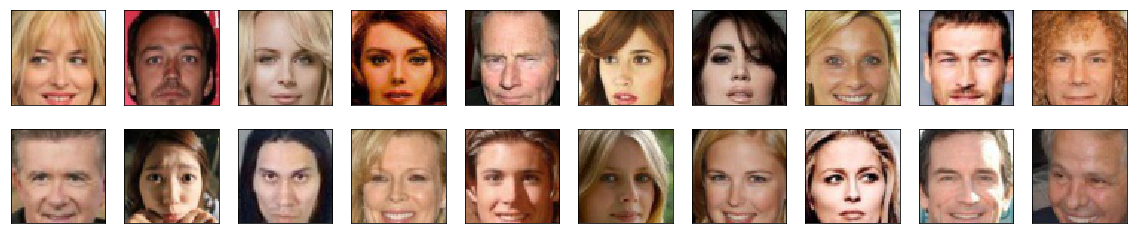

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

I need to do a bit of pre-processing; the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, so I need to rescale our training images to a range of -1 to 1.

In [7]:
def scale(x, feature_range=(-1, 1)):
    """
    Scale takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1. 
    This function assumes that the input x is already scaled from 0-1.
    
    Args:
        x (Tensor)
        feature_range (Tuple of int)
    
    Return: Re-scaled Tensor
    """
    # we can assume that x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min_x, max_x = feature_range
    x = x * (max_x - min_x) + min_x
    return x


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

This is a convolutional classifier network, only without any maxpooling layers. To deal with this complex data, it's better to use a deep network with **batch normalization**. 

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    
    Args:
        in_channels (int): 
            Number of channels in the input image
        out_channels (int): 
            Number of channels produced by the convolution
        kernel_size (int or tuple): 
            Size of the convolving kernel
        stride (int or tuple, optional): 
            Stride of the convolution. Default: 2
        padding (int or tuple, optional): 
            Zero-padding added to both sides of the input. Default: 1
        batch_norm (bool):
            Whether or not to add batch normalization. Default: True
    
    Return:
        Sequential list of layers
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, 
                           bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [5]:
class Discriminator(nn.Module):
    """
    The inputs to the discriminator are 3 (channels) x image_size x image_size tensor images.
    The output should be a single value that will indicate whether a given image is real or fake.
    """

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        Args:
            conv_dim (int): The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # 3x64x64
        self.conv1 = conv(in_channels=3, 
                          out_channels=conv_dim, 
                          kernel_size=4, 
                          batch_norm=False)
        # 32x32x32
        self.conv2 = conv(in_channels=conv_dim, 
                          out_channels=conv_dim*2, 
                          kernel_size=4)
        # (32x2)x16x16
        self.conv3 = conv(in_channels=conv_dim*2, 
                          out_channels=conv_dim*4, 
                          kernel_size=4)
        # (32x4)x8x8
        self.conv4 = conv(in_channels=conv_dim*4, 
                          out_channels=conv_dim*8, 
                          kernel_size=4)
        # (32x8)x4x4
        self.fc = nn.Linear(conv_dim*8*4*4, 1) # -> output: 1
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        
        Args:
            x (Tensor): The input to the neural network     
        
        Return:
            Discriminator logits; the output of the neural network
        """
        
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))
        
        # flatten
        x = x.view(-1, self.conv_dim*8*4*4)
        
        x = self.fc(x)
        
        return x

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `3x64x64`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    
    Args:
        in_channels (int): 
            Number of channels in the input image
        out_channels (int): 
            Number of channels produced by the convolution
        kernel_size (int or tuple): 
            Size of the convolving kernel
        stride (int or tuple, optional): 
            Stride of the convolution. Default: 2
        padding (int or tuple, optional): 
            ``kernel_size - 1 - padding`` zero-padding will be added 
            to both sides of each dimension in the input. Default:1
        batch_norm (bool):
            Whether or not to add batch normalization. Default: True
        
    Return:
        Sequential list of layers
    """
    
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                      kernel_size, stride, padding, 
                                      bias=False)
    
    # append deconv layer
    layers.append(deconv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [13]:
class Generator(nn.Module):
    """
    The inputs to the generator are vectors of some length `z_size`
    The output should be a image of shape 3 (channels) x image_size x image_size
    """
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        
        Args:
            z_size (int): The length of the input latent vector, z
            conv_dim (int): 
                The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # 100
        self.fc = nn.Linear(z_size, conv_dim*8*4*4)
        # (32x8)x4x4
        self.deconv1 = deconv(in_channels=conv_dim*8, 
                              out_channels=conv_dim*4, 
                              kernel_size=4)
        # (32x4)x8x8
        self.deconv2 = deconv(in_channels=conv_dim*4, 
                              out_channels=conv_dim*2, 
                              kernel_size=4)
        # (32x2)x16x16
        self.deconv3 = deconv(in_channels=conv_dim*2, 
                              out_channels=conv_dim, 
                              kernel_size=4)
        # 32x32x32
        self.deconv4 = deconv(in_channels=conv_dim, 
                              out_channels=3, 
                              kernel_size=4, 
                              batch_norm=False) # -> output: 3x64x64
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        
        Args:
            x (Tensor): The input to the neural network
        
        Return:
            A 3x64x64 Tensor image as output
        """
        
        x = self.fc(x)
        
        # reshape
        x = x.view(-1, self.conv_dim*8, 4, 4) # (batch_size, channels, 4, 4)
        
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.tanh(self.deconv4(x))
        
        return x

## Initialize the weights of the networks

To help the models converge, would be a good idea to initialize the weights of the convolutional and linear layers in the model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to convolutional and linear layers in a model.
    The bias terms, if they exist, may be left alone or set to 0.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    
    Args:
        m (torch.nn.Module): A module or layer in a network    
    """
    
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Based on the networks.py file in CycleGAN Github repository
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or \
                                 classname.find('Linear') != -1):
        
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    
    elif classname.find('BatchNorm') != -1:
        # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    
    

## Complete network

In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(

### Training on GPU

In [17]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [18]:
def real_loss(D_out, smooth=False):
    """
    Calculates how close discriminator outputs are to being real.
    
    Args:
        D_out (Tensor): discriminator logits
        smooth (bool): label smoothing
    
    Return: real loss
    """
    
    batch_size = D_out.size(0)
    
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    """
    Calculates how close discriminator outputs are to being fake.
    
    Args:
        D_out (Tensor): discriminator logits
        smooth (bool): label smoothing
    
    Return: fake loss
    """
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

In [19]:
import torch.optim as optim

# params
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
beta2= 0.999

# Optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. The functions `real_loss` and `fake_loss` will help to calculate the discriminator losses.

The discriminator is trained by alternating on real and fake images. Then the generator, which tries to trick the discriminator and should have an opposing loss function.

In [20]:
def generate_images(batch_size, z_size):
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()

    # move x to GPU, if available
    if train_on_gpu:
        z = z.cuda()

    return G(z)

In [21]:
def train(D, G, n_epochs, print_every=50):
    """
    Trains adversarial networks for some number of epochs
    
    Args:
       D (Discriminator): the discriminator network
       G (Generator): the generator network
       n_epochs (int): number of epochs to train for
       print_every (int): when to print and record the models' losses. Default: 50
    
    Return: D and G losses
    """
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real, True) # smoothing label 1 => 0.9

            # 2. Train with fake images

            # Generate fake images
            fake_images = generate_images(batch_size, z_size)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            # Generate fake images
            fake_images = generate_images(batch_size, z_size)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH ##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [22]:
# set number of epochs 
n_epochs = 10

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.8279 | g_loss: 2.9645
Epoch [    1/   10] | d_loss: 0.5490 | g_loss: 9.3273
Epoch [    1/   10] | d_loss: 0.5448 | g_loss: 4.1429
Epoch [    1/   10] | d_loss: 0.7798 | g_loss: 5.9538
Epoch [    1/   10] | d_loss: 0.8439 | g_loss: 7.6298
Epoch [    1/   10] | d_loss: 0.5785 | g_loss: 3.8693
Epoch [    1/   10] | d_loss: 0.6727 | g_loss: 3.5498
Epoch [    1/   10] | d_loss: 0.6439 | g_loss: 4.2586
Epoch [    1/   10] | d_loss: 1.0330 | g_loss: 0.8741
Epoch [    1/   10] | d_loss: 0.9147 | g_loss: 5.4797
Epoch [    1/   10] | d_loss: 1.0333 | g_loss: 6.4289
Epoch [    1/   10] | d_loss: 1.2584 | g_loss: 1.7895
Epoch [    1/   10] | d_loss: 0.6101 | g_loss: 4.1843
Epoch [    1/   10] | d_loss: 0.8432 | g_loss: 2.3089
Epoch [    1/   10] | d_loss: 0.7615 | g_loss: 2.9970
Epoch [    1/   10] | d_loss: 0.8330 | g_loss: 3.3401
Epoch [    1/   10] | d_loss: 1.6624 | g_loss: 2.9124
Epoch [    1/   10] | d_loss: 0.7404 | g_loss: 2.7569
Epoch [    1/   10] | d_loss

## Training loss

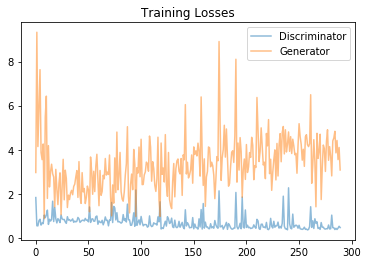

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Samples from training

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

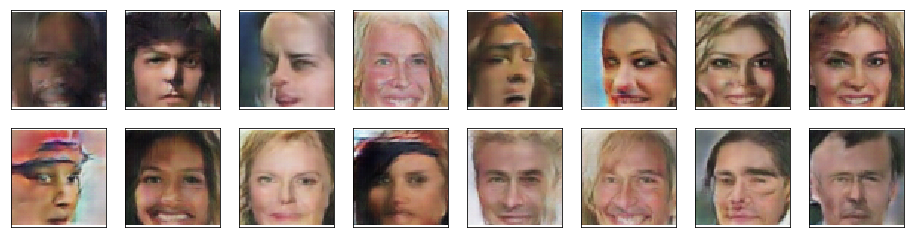

In [26]:
_ = view_samples(-1, samples)